In [1]:
import cv2
import requests
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO

In [2]:
def load_image_from_url(url: str) -> Image.Image:
    response = requests.get(url)
    image_data = BytesIO(response.content)
    
    return Image.open(image_data)

def pil_to_cv2(pil_image: Image.Image) -> np.ndarray:
    pil_image = pil_image.convert('RGB')
    cv2_image = np.array(pil_image)
    # Convert RGB to BGR
    cv2_image = cv2_image[:, :, ::-1].copy()
    
    return cv2_image

def resize_with_pad(im, target_width, target_height, is_4c=True):
    target_ratio = target_height / target_width
    im_ratio = im.height / im.width
    if target_ratio > im_ratio:
        # It must be fixed by width
        resize_width = target_width
        resize_height = round(resize_width * im_ratio)
    else:
        # Fixed by height
        resize_height = target_height
        resize_width = round(resize_height / im_ratio)

    image_resize = im.resize((resize_width, resize_height), Image.LANCZOS)
    background = Image.new('RGBA', (target_width, target_height), (0, 0, 0, 0))
    offset = (round((target_width - resize_width) / 2), round((target_height - resize_height) / 2))
    background.paste(image_resize, offset)
    if not is_4c:
        background = background.convert("RGB")
    return background

In [3]:
from aura_sr import AuraSR

aura_sr = AuraSR.from_pretrained("fal/AuraSR-v2")

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
resize_size = (512,512)

image = Image.open("./assets/0_sample_input.png")
image = resize_with_pad(image, resize_size[0], resize_size[1])
img_3c = np.array(image)[:,:,:3]
img_c4 = np.array(image)[:,:,3]

upscaled_image = aura_sr.upscale_4x_overlapped(Image.fromarray(img_3c))
upscaled_image = resize_with_pad(upscaled_image, resize_size[0], resize_size[1], is_4c=False)
upscaled_image = Image.fromarray(np.dstack((np.array(upscaled_image), img_c4)))

In [ ]:
# Calculate the per-element absolute difference between 
# two arrays or between an array and a scalar
diff = 255 - cv2.absdiff(pil_to_cv2(upscaled_image), pil_to_cv2(image))
diff = Image.fromarray(diff)

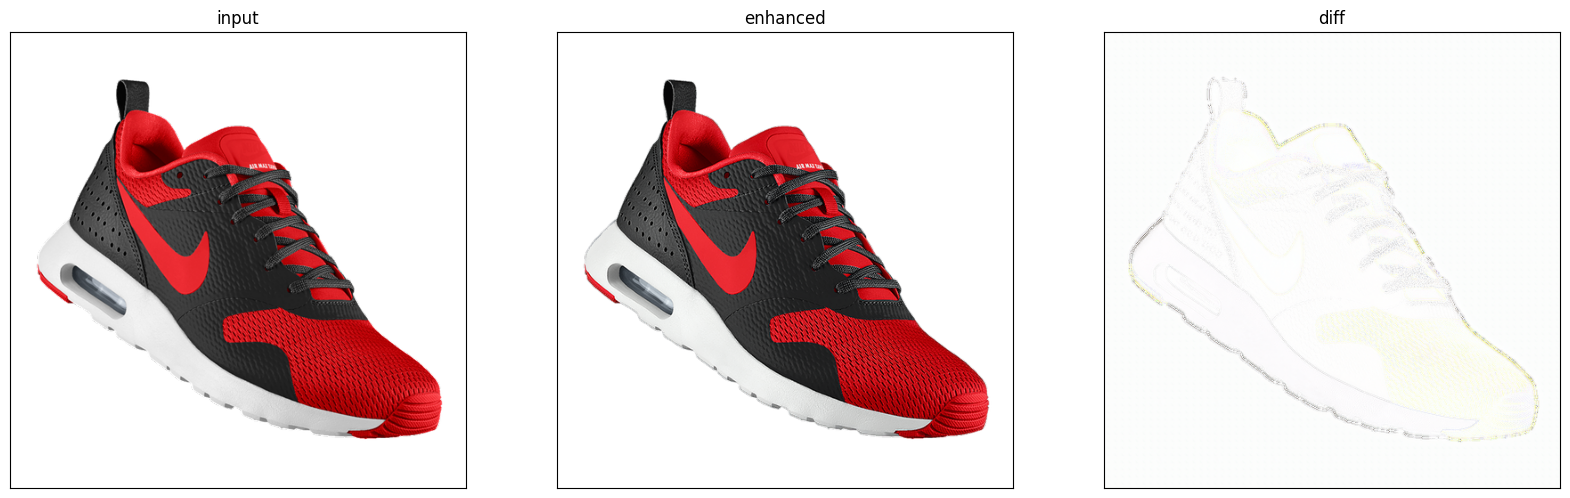

In [ ]:
f, axes = plt.subplots(1,3, figsize=(20,20))
axes[0].imshow(image)
axes[0].set_title('input')
axes[1].imshow(upscaled_image)
axes[1].set_title('enhanced')
axes[2].imshow(diff)
axes[2].set_title('diff')

# remove the x and y ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
# upscaled_image.save("./assets/1_enhanced.png")